In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistics

This notebook provides examples for extracting useful statistics from processed hdf5 data.

In [3]:
from e11 import H5Data
from e11.stats import statistics
from e11.tools import add_level
from e11.process import vrange

In [4]:
# read file
import os 
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil)

In [5]:
data.log

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 666.84it/s]


,ACQUIRE,DATETIME,END,ERROR,LOOP,OVERRIDE,START,VAR:PAUSE,ELAPSED
squid,,,,,,,,,
1,10.036975,2017-12-01 15:41:22,3.594988e+09,0,1,0,3.594988e+09,300,00:00:00
2,10.021719,2017-12-01 15:41:33,3.594988e+09,0,1,0,3.594988e+09,600,00:00:11
3,10.034403,2017-12-01 15:41:45,3.594988e+09,0,1,0,3.594988e+09,900,00:00:23
4,10.022052,2017-12-01 15:41:55,3.594988e+09,0,2,0,3.594988e+09,300,00:00:33
5,10.027435,2017-12-01 15:42:06,3.594988e+09,0,2,0,3.594988e+09,600,00:00:44
6,10.027131,2017-12-01 15:42:18,3.594988e+09,0,2,0,3.594988e+09,900,00:00:56


In [20]:
data.log['END'] - data.log['START']

squid
1    10.036975
2    10.021719
3    10.034403
4    10.022052
5    10.027435
6    10.027131
dtype: float64

## Vrange

Here, we are applying the vrange function to measure the vertical range of array data.

In [6]:
rng = data.apply(vrange, data.squids, 'OSC_0')
rng.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.94sq/s]


vrange
squid measurement          
1     0            1.033028
      1            1.012191
      2            1.032403
      3            1.070328
      4            1.062143

In [7]:
rng.describe()

,vrange
count,151.000000
mean,1.039718
std,0.015097
min,0.997321
25%,1.031731
50%,1.041619
75%,1.050006
max,1.083854


##  Statistics

The `statistics()` function can be used to find the average vrange value per squid.

In [8]:
av = statistics(rng, mode='full')
av.head()

vrange                                                              \
       count       err       max      mean    median       min     range   
squid                                                                      
1         25  0.003350  1.070328  1.038482  1.039619  1.000539  0.069789   
2         25  0.002847  1.064080  1.039364  1.042150  1.002382  0.061698   
3         26  0.001758  1.061674  1.043457  1.043071  1.020032  0.041642   
4         25  0.002988  1.083854  1.044290  1.042212  1.020626  0.063229   
5         25  0.003784  1.063393  1.034683  1.033215  0.997321  0.066072   

                 
            std  
squid            
1      0.016752  
2      0.014236  
3      0.008966  
4      0.014941  
5      0.018921

In [9]:
# map measurements to var values
df = add_level(data.var, 'VAR').join(av)
df.head()

VAR vrange                                                    \
      PAUSE  count       err       max      mean    median       min   
squid                                                                  
1       300     25  0.003350  1.070328  1.038482  1.039619  1.000539   
2       600     25  0.002847  1.064080  1.039364  1.042150  1.002382   
3       900     26  0.001758  1.061674  1.043457  1.043071  1.020032   
4       300     25  0.002988  1.083854  1.044290  1.042212  1.020626   
5       600     25  0.003784  1.063393  1.034683  1.033215  0.997321   

                           
          range       std  
squid                      
1      0.069789  0.016752  
2      0.061698  0.014236  
3      0.041642  0.008966  
4      0.063229  0.014941  
5      0.066072  0.018921

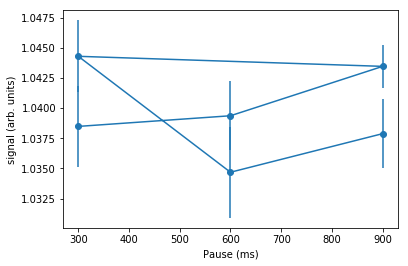

In [10]:
# plot
fig, ax = plt.subplots()

xvals = df[('VAR', 'PAUSE')]
yvals = df[('vrange', 'mean')]
yerr =  df[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('Pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()

## Loops

It's not unusual for different squids to be run using the same experimental conditions (VARS), e.g., if looping an experiment script.

The plot above indicates that there were 2 loops recorded using the same values for VAR:PAUSE.  These can simply be grouped together to find the overall statistics for unique VAR values.

In [11]:
# map measurements to var values
df2 = data.var.join(rng)
df2.head()

PAUSE    vrange
squid measurement                 
1     0              300  1.033028
      1              300  1.012191
      2              300  1.032403
      3              300  1.070328
      4              300  1.062143

In [12]:
# then evaluate the statistics when grouped by var values
st = statistics(df2, groupby=data.var.columns, mode='full')
st.head()

vrange                                                              \
       count       err       max      mean    median       min     range   
PAUSE                                                                      
300       50  0.002260  1.083854  1.041386  1.040635  1.000539  0.083316   
600       50  0.002367  1.064080  1.037024  1.042134  0.997321  0.066759   
900       51  0.001702  1.069203  1.040724  1.041619  1.012878  0.056325   

                 
            std  
PAUSE            
300    0.015981  
600    0.016739  
900    0.012155

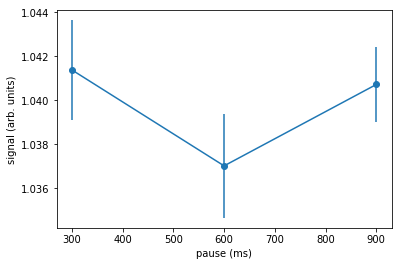

In [13]:
# plot
fig, ax = plt.subplots()

xvals = st.index.get_level_values('PAUSE')
yvals = st[('vrange', 'mean')]
yerr =  st[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()

## Combing data from multiple runs

Sometimes it's useful to combine data from different runs using pandas.concat.

In [14]:
# import data
run_ids = ['20180720_000', '20180720_001']
all_data = dict()
for rid in run_ids:
    # normally we'd use run_file()
    # >>> fil = run_file(base="Q:\E11_atmos\data", rid=rid)
    # but for now we'll use the example data, again, err.., twice.
    fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
    # open
    all_data[rid] = H5Data(fil)

### workflow #1

Seperate results for each run -- e.g., for comparing runs.

In [15]:
all_st = dict()
for rid in run_ids:
    # calculate vertical range
    data = all_data[rid]
    rng = data.apply(vrange, data.squids, 'OSC_0', tqdm_disable=True)
    df = data.var.join(rng)
    # calculate statistics
    st = statistics(df2, groupby=data.var.columns, mode='full', tqdm_disable=True)
    all_st[rid] = st
# result
all_st = pd.concat(all_st, names=['rid'])
all_st

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2001.10it/s]


vrange                                                    \
                    count       err       max      mean    median       min   
rid          PAUSE                                                            
20180720_000 300       50  0.002260  1.083854  1.041386  1.040635  1.000539   
             600       50  0.002367  1.064080  1.037024  1.042134  0.997321   
             900       51  0.001702  1.069203  1.040724  1.041619  1.012878   
20180720_001 300       50  0.002260  1.083854  1.041386  1.040635  1.000539   
             600       50  0.002367  1.064080  1.037024  1.042134  0.997321   
             900       51  0.001702  1.069203  1.040724  1.041619  1.012878   

                                        
                       range       std  
rid          PAUSE                      
20180720_000 300    0.083316  0.015981  
             600    0.066759  0.016739  
             900    0.056325  0.012155  
20180720_001 300    0.083316  0.015981  
             600    0.066759  0.016739  
             900    0.056325  0.012155

### workflow #2

Combine results -- e.g., to improve statistics (don't actually do this using identical data!).

In [16]:
all_df = dict()
for rid in run_ids:
    data = all_data[rid]
    rng = data.apply(vrange, data.squids, 'OSC_0', tqdm_disable=True)
    all_df[rid] = data.var.join(rng)
# combine vertical range measurements
all_df = pd.concat(all_df, names=['rid'])
all_df.head()

PAUSE    vrange
rid          squid measurement                 
20180720_000 1     0              300  1.033028
                   1              300  1.012191
                   2              300  1.032403
                   3              300  1.070328
                   4              300  1.062143

In [17]:
# calculate statistics
st = statistics(all_df, groupby=data.var.columns, mode='full')
st

vrange                                                              \
       count       err       max      mean    median       min     range   
PAUSE                                                                      
300      100  0.001590  1.083854  1.041386  1.040635  1.000539  0.083316   
600      100  0.001665  1.064080  1.037024  1.042134  0.997321  0.066759   
900      102  0.001198  1.069203  1.040724  1.041619  1.012878  0.056325   

                 
            std  
PAUSE            
300    0.015901  
600    0.016654  
900    0.012095